In [5]:
#Importing packages
import requests
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [15]:
#DMI requires a personal key to access their API
api_key = '12a4bffe-21d5-4154-96e5-12bf959cc1dd'
api_key2 = '698c1af9-1c82-4b60-bca5-779095dacd29'

In [3]:
#Defining URL for the API
url = 'https://dmigw.govcloud.dk/metObs/v1/observation'

In [4]:
#Defining data period
end_time = pd.datetime.today()
start_time = pd.datetime(2015,1,1)

#Creates function that convertes datetime objects to Unix microsecond string
def date_time(dt):
    '''
    Function convertes datetime objects to Unix microsecond string
    '''
    return str(int(pd.to_datetime(dt).value*10**-3))

#Specifying query parameters: 
#Personal API-key, data period by using our function, stationId (06185 is the DMI station at Østerbro, Kbh), 
#parameterId (temp_dry is "Present air temperature measured 2 m over terrain every 10 min") and finally the limit
#which should be more than 6*24*(365+365+235+735)=138960 (incl. 22 of august)
params = {'api-key' : api_key,
          'from' : date_time(start_time),
          'to' : date_time(end_time),
          'stationId' : '06184',
          'parameterId' : 'temp_dry',
          'limit' : '10000000',
          }
#Requests and gets URL for the chosen query parameters.
r = requests.get(url, params=params)
print(r, r.url)

<Response [200]> https://dmigw.govcloud.dk/metObs/v1/observation?api-key=12a4bffe-21d5-4154-96e5-12bf959cc1dd&from=1420070400000000&to=1598540931635277&stationId=06184&parameterId=temp_dry&limit=10000000


In [8]:
#Defining data period
end_time = pd.datetime(2015,5,27)
start_time = pd.datetime(2010,1,1)

#Creates function that convertes datetime objects to Unix microsecond string
def date_time(dt):
    '''
    Function convertes datetime objects to Unix microsecond string
    '''
    return str(int(pd.to_datetime(dt).value*10**-3))

#Specifying query parameters: 
#Personal API-key, data period by using our function, stationId (06185 is the DMI station at Østerbro, Kbh), 
#parameterId (temp_dry is "Present air temperature measured 2 m over terrain every 10 min") and finally the limit
#which should be more than 6*24*(365+365+235+735)=138960 (incl. 22 of august)
params = {'api-key' : api_key,
          'from' : date_time(start_time),
          'to' : date_time(end_time),
          'stationId' : '06184',
          'parameterId' : 'temp_dry',
          'limit' : '10000000',
          }
#Requests and gets URL for the chosen query parameters.
r2 = requests.get(url, params=params)
print(r, r.url)

<Response [200]> https://dmigw.govcloud.dk/metObs/v1/observation?api-key=12a4bffe-21d5-4154-96e5-12bf959cc1dd&from=1420070400000000&to=1598540931635277&stationId=06184&parameterId=temp_dry&limit=10000000


In [20]:
#Extracting JSON
json = r.json()

#Convertes JSON to Pandas DataFrame
df = pd.DataFrame(json)

#Creates time varaible with format YYYY-MM-DD HH:MM:SS
df['time'] = pd.to_datetime(df['timeObserved'], unit='us')

#Drop irrelevant variables
df = df.drop(['_id', 'timeCreated', 'timeObserved'], axis=1)

#Index the time variables
df.index = df['time']
df

,parameterId,stationId,value,time
time,,,,
2020-08-27 13:00:00,temp_dry,06184,17.2,2020-08-27 13:00:00
2020-08-27 12:50:00,temp_dry,06184,17.0,2020-08-27 12:50:00
2020-08-27 12:40:00,temp_dry,06184,16.8,2020-08-27 12:40:00
2020-08-27 12:30:00,temp_dry,06184,16.8,2020-08-27 12:30:00
2020-08-27 12:20:00,temp_dry,06184,16.7,2020-08-27 12:20:00
...,...,...,...,...
2015-05-28 13:10:00,temp_dry,06184,12.4,2015-05-28 13:10:00
2015-05-28 13:00:00,temp_dry,06184,14.3,2015-05-28 13:00:00
2015-05-28 12:50:00,temp_dry,06184,15.2,2015-05-28 12:50:00


In [10]:
#Extracting JSON
json2 = r2.json()

#Convertes JSON to Pandas DataFrame
df2 = pd.DataFrame(json2)

#Creates time varaible with format YYYY-MM-DD HH:MM:SS
df2['time'] = pd.to_datetime(df2['timeObserved'], unit='us')

#Drop irrelevant variables
df2 = df2.drop(['_id', 'timeCreated', 'timeObserved'], axis=1)

#Index the time variables
df2.index = df2['time']
df2

,parameterId,stationId,value,time
time,,,,
2014-11-06 12:10:00,temp_dry,06184,8.7,2014-11-06 12:10:00
2014-11-06 12:00:00,temp_dry,06184,8.6,2014-11-06 12:00:00
2014-11-06 11:50:00,temp_dry,06184,8.7,2014-11-06 11:50:00
2014-11-06 11:40:00,temp_dry,06184,8.6,2014-11-06 11:40:00
2014-11-06 11:30:00,temp_dry,06184,8.6,2014-11-06 11:30:00
...,...,...,...,...
2010-01-01 00:40:00,temp_dry,06184,-6.8,2010-01-01 00:40:00
2010-01-01 00:30:00,temp_dry,06184,-6.9,2010-01-01 00:30:00
2010-01-01 00:20:00,temp_dry,06184,-6.8,2010-01-01 00:20:00


In [23]:
#Creates date variable with format YYYY-MM-DD
df['date']=df.time.astype(str).str[:10]
df['mdr']=df.time.astype(str).str[:7]
df['month'] = df['time'].dt.month
df['year'] = df['time'].dt.year
df

,parameterId,stationId,value,time,date,mdr,month,year
time,,,,,,,,
2020-08-27 13:00:00,temp_dry,06184,17.2,2020-08-27 13:00:00,2020-08-27,2020-08,8,2020
2020-08-27 12:50:00,temp_dry,06184,17.0,2020-08-27 12:50:00,2020-08-27,2020-08,8,2020
2020-08-27 12:40:00,temp_dry,06184,16.8,2020-08-27 12:40:00,2020-08-27,2020-08,8,2020
2020-08-27 12:30:00,temp_dry,06184,16.8,2020-08-27 12:30:00,2020-08-27,2020-08,8,2020
2020-08-27 12:20:00,temp_dry,06184,16.7,2020-08-27 12:20:00,2020-08-27,2020-08,8,2020
...,...,...,...,...,...,...,...,...
2015-05-28 13:10:00,temp_dry,06184,12.4,2015-05-28 13:10:00,2015-05-28,2015-05,5,2015
2015-05-28 13:00:00,temp_dry,06184,14.3,2015-05-28 13:00:00,2015-05-28,2015-05,5,2015
2015-05-28 12:50:00,temp_dry,06184,15.2,2015-05-28 12:50:00,2015-05-28,2015-05,5,2015


In [25]:
#Creates date variable with format YYYY-MM-DD
df2['date']=df2.time.astype(str).str[:10]
df2['mdr']=df2.time.astype(str).str[:7]
df2['month'] = df2['time'].dt.month
df2['year'] = df2['time'].dt.year
df2

,parameterId,stationId,value,time,date,mdr,month,year
time,,,,,,,,
2014-11-06 12:10:00,temp_dry,06184,8.7,2014-11-06 12:10:00,2014-11-06,2014-11,11,2014
2014-11-06 12:00:00,temp_dry,06184,8.6,2014-11-06 12:00:00,2014-11-06,2014-11,11,2014
2014-11-06 11:50:00,temp_dry,06184,8.7,2014-11-06 11:50:00,2014-11-06,2014-11,11,2014
2014-11-06 11:40:00,temp_dry,06184,8.6,2014-11-06 11:40:00,2014-11-06,2014-11,11,2014
2014-11-06 11:30:00,temp_dry,06184,8.6,2014-11-06 11:30:00,2014-11-06,2014-11,11,2014
...,...,...,...,...,...,...,...,...
2010-01-01 00:40:00,temp_dry,06184,-6.8,2010-01-01 00:40:00,2010-01-01,2010-01,1,2010
2010-01-01 00:30:00,temp_dry,06184,-6.9,2010-01-01 00:30:00,2010-01-01,2010-01,1,2010
2010-01-01 00:20:00,temp_dry,06184,-6.8,2010-01-01 00:20:00,2010-01-01,2010-01,1,2010


In [28]:
#Calculates monthly average
mean=df.groupby([ 'mdr'])['value'].mean().copy()
mean

mdr
2015-05    11.864000
2015-06    14.586846
2015-07    17.486242
2015-08    18.730390
2015-09    14.370063
             ...    
2020-04     8.400741
2020-05    11.147368
2020-06    17.608223
2020-07    15.999776
2020-08    20.055209
Name: value, Length: 64, dtype: float64

In [27]:
#Calculates monthly average
mean2=df2.groupby([ 'mdr'])['value'].mean().copy()
mean

mdr
2010-01    -2.511508
2010-02    -1.219032
2010-03     3.262522
2010-04     7.838814
2010-05    10.449047
2010-06    15.195849
2010-07    20.433111
2010-08    17.356607
2010-09    13.401574
2010-10     8.788665
2010-11     3.832616
2010-12    -3.197872
2011-01     0.386694
2011-02     0.032639
2011-03     3.371645
2011-04    10.626502
2011-05    12.493161
2011-06    16.784649
2011-07    17.653497
2011-08    17.132937
2011-09    14.814008
2011-10    10.198253
2011-11     7.225637
2011-12     4.583154
2012-01     2.422040
2012-02    -0.132184
2012-03     6.165969
2012-04     6.981296
2012-05    13.198160
2012-06    14.054468
2012-07    17.489091
2012-08    17.932180
2012-09    14.060309
2012-10     9.239701
2012-11     6.690160
2012-12     0.865009
2013-01     0.531317
2013-02    -0.096924
2013-03    -0.381620
2013-04     6.655532
2013-05    13.430394
2013-06    16.083129
2013-07    18.951154
2013-08    18.078562
2013-09    13.695810
2013-10    11.597267
2013-11     6.443793
2013-12  

In [29]:
#Creates DataFrame based on mean
df_weather = pd.DataFrame(data = mean , index = mean.index)
df_weather2 = pd.DataFrame(data = mean2 , index = mean2.index)

df_weather = pd.concat([df_weather2 , df_weather])

df_weather.to_csv(r'C:\Users\Bruger\Documents\GitHub\Group19\EXAM\dmi_join_rdy.csv')

df_weather

,value
mdr,
2010-01,-2.511508
2010-02,-1.219032
2010-03,3.262522
2010-04,7.838814
2010-05,10.449047
...,...
2020-04,8.400741
2020-05,11.147368
2020-06,17.608223


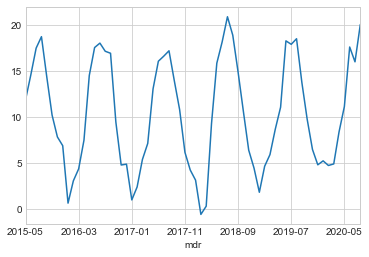

In [30]:
#Generate plot of data - dayly average
avg_temp = df.groupby('mdr')['value'].agg('mean')
avg_temp.plot()
plt.show()

Text(0.5, 0, '')

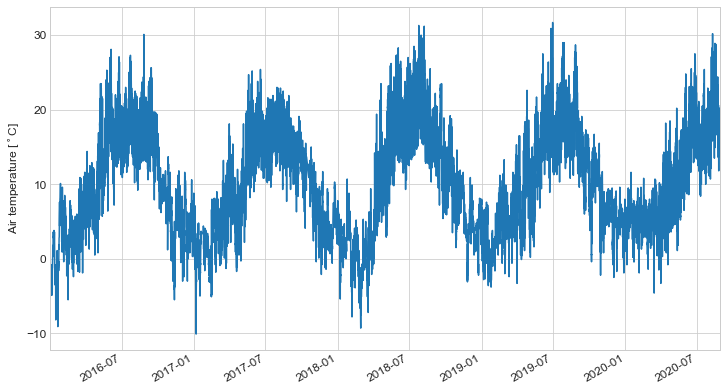

In [11]:
#Deletes data duplicates
df2 = df.set_index(['time', 'parameterId']).drop_duplicates().unstack(level=-1)['value'].copy()

#Generate plot of data - 10 min
ax = df2['temp_dry'].interpolate().plot(figsize=(12,7), legend=False, fontsize=12, subplots=True)
ax[0].set_ylabel('Air temperature [$^\circ$C]', size=12)
ax[0].set_xlabel('', size=12)

In [33]:
#data
total = pd.read_csv(r'dmi_join_rdy.csv' , sep = ',')

In [28]:
#total.value[47:52]

47    5.314945
48    1.644932
49    4.217320
50    6.394351
51    9.449282
Name: value, dtype: float64

In [34]:
#missing values
mv=pd.DataFrame({'date':['2014-12','2015-01','2015-02','2015-03','2015-04'], 'value':total.value[47:52]})
final=total.append(mv)

In [35]:
final.to_csv(r'df_weather_final.csv')
